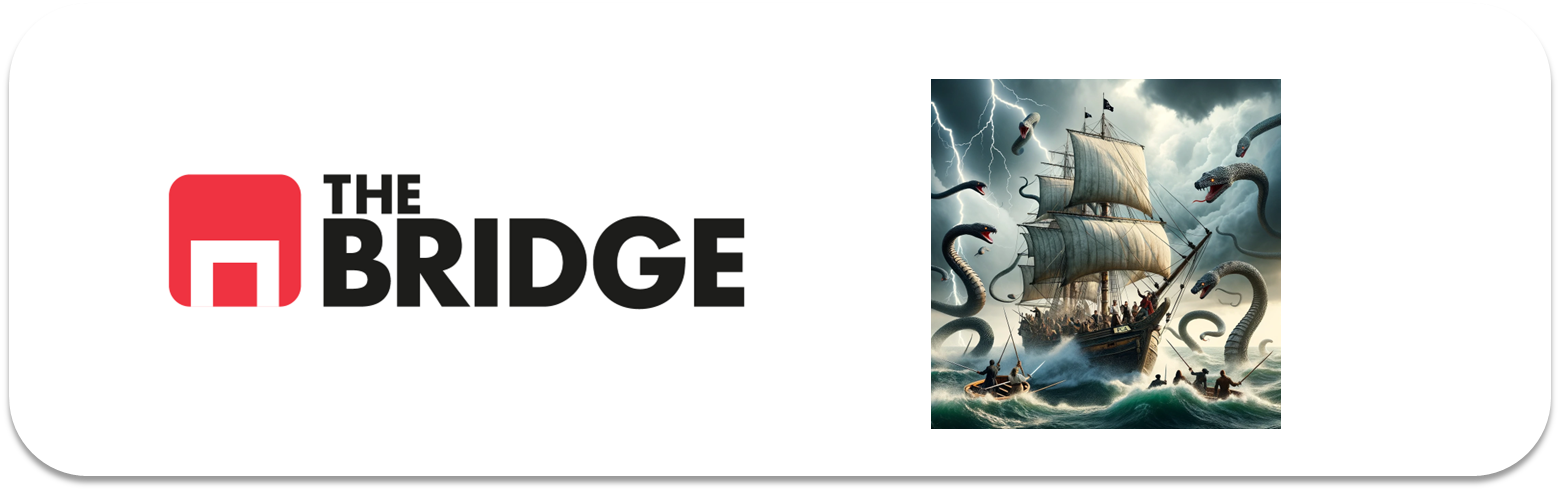

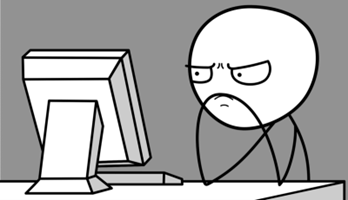

Para ejercitarte y afianzar lo aprendido sobre **Seleccion de Features**, completa los siguientes ejercicios. Recuerda que necesitarás datos que están en el directorio data que acompaña al notebook (búscalo en el repositorio de ejercicios)
  
La solución a los mismos las tienes ya, intenta no mirarlos de primeras pero no dejes de hacerlo cuando hayas terminado por si te pudieran aportar.

## Feature selection: Breast Cancer Winsconsin

El objetivo de este grupo de ejercicio es dar a entender la importancia de la selección de características (features), así como probar distintos métodos de reducción de características (features) y qué influencia puede tener el reducir features en el perfomance de un modelo. Nuestro target para evaluar el perfomance será si estamos ante tumores malignos o benignos.

Vamos a trabajar con el dataset de Breast Cancer Winsconsin, datos tomados a partir de radiografías.

### Ejercicio 0

Importa los paquetes y módulos que necesites a lo largo del notebook

In [1]:
import bootcampviztools as bt
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.feature_selection import SelectKBest, f_classif

#import warnings library
import warnings
# ignore all warnings
warnings.filterwarnings('ignore')

### Ejercicio 1:

Carga los datos y haz una primera inspección de los mismos y comenta lo que creas conveniente sobre las features y su relación entre sí (pero sin analizarlas numéricamente)

In [2]:
df_breast_cancer = pd.read_csv('./breastcancer-winsconsin.csv')
df_breast_cancer.head()

,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,...,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst,Unnamed: 32
0,842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,...,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,NaN
1,842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,...,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,NaN
2,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,...,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,NaN
3,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,...,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,NaN
4,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,...,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,NaN


In [3]:
df_breast_cancer.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 569 entries, 0 to 568
Data columns (total 33 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   id                       569 non-null    int64  
 1   diagnosis                569 non-null    object 
 2   radius_mean              569 non-null    float64
 3   texture_mean             569 non-null    float64
 4   perimeter_mean           569 non-null    float64
 5   area_mean                569 non-null    float64
 6   smoothness_mean          569 non-null    float64
 7   compactness_mean         569 non-null    float64
 8   concavity_mean           569 non-null    float64
 9   concave points_mean      569 non-null    float64
 10  symmetry_mean            569 non-null    float64
 11  fractal_dimension_mean   569 non-null    float64
 12  radius_se                569 non-null    float64
 13  texture_se               569 non-null    float64
 14  perimeter_se             5

*Tenemos un dataset de 31 features (el índice y la Unnamed no cuentan :-), sobre 569 instancias. ¿Son muchas? Son más de un 5% (31 sobre 569) que no son pocas, pero sobre todo son bastantes en términos absolutos (31). No estará de más hacer una reducción aunque sea para tratar mejor la explicabilidad de un modelo que va a predecir algo tan sensible como la posibilidad de tener un cáncer*

*Además si te fijas en las features, tenemos realmente 12 medidas y muchas derivadas (media, desviación estándar y "worst" ((media de los tres valores mas grandes), así que seguramente una reducción de features quitando valores muy ligados o colineales podrá sentarle bien a un hipotético modelo de clasificación*

1. **id**
1. **diagnosis (M = Maligno, B = Benigno)**
1. **radius (media de distancias desde el centro hasta los puntos del perímetro)**
1. **texture (desviación estándar de valores en escala de grises)**
1. **perimeter**
1. **area**
1. **smoothness (variación local en longitudes de radio)**
1. **compactness (perimeter^2 / area - 1.0)**
1. **concavity (severidad de porciones cóncavas del contorno)**
1. **concave points (número de porciones cóncavas del contorno)**
1. **symmetry**
1. **fractal dimension ("coastline approximation" - 1)**
<br>
* El "mean", "standard error" y "worst" (media de los tres valores mas grandes) es proporcionado para cada imagen, resultando en 30 features


### Ejercicio 2:

Descarta las características que evidentemente no aportan información.

In [4]:
df_breast_cancer.describe()

,id,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,...,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst,Unnamed: 32
count,5.690000e+02,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,...,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,0.0
mean,3.037183e+07,14.127292,19.289649,91.969033,654.889104,0.096360,0.104341,0.088799,0.048919,0.181162,...,25.677223,107.261213,880.583128,0.132369,0.254265,0.272188,0.114606,0.290076,0.083946,NaN
std,1.250206e+08,3.524049,4.301036,24.298981,351.914129,0.014064,0.052813,0.079720,0.038803,0.027414,...,6.146258,33.602542,569.356993,0.022832,0.157336,0.208624,0.065732,0.061867,0.018061,NaN
min,8.670000e+03,6.981000,9.710000,43.790000,143.500000,0.052630,0.019380,0.000000,0.000000,0.106000,...,12.020000,50.410000,185.200000,0.071170,0.027290,0.000000,0.000000,0.156500,0.055040,NaN
25%,8.692180e+05,11.700000,16.170000,75.170000,420.300000,0.086370,0.064920,0.029560,0.020310,0.161900,...,21.080000,84.110000,515.300000,0.116600,0.147200,0.114500,0.064930,0.250400,0.071460,NaN
50%,9.060240e+05,13.370000,18.840000,86.240000,551.100000,0.095870,0.092630,0.061540,0.033500,0.179200,...,25.410000,97.660000,686.500000,0.131300,0.211900,0.226700,0.099930,0.282200,0.080040,NaN
75%,8.813129e+06,15.780000,21.800000,104.100000,782.700000,0.105300,0.130400,0.130700,0.074000,0.195700,...,29.720000,125.400000,1084.000000,0.146000,0.339100,0.382900,0.161400,0.317900,0.092080,NaN
max,9.113205e+08,28.110000,39.280000,188.500000,2501.000000,0.163400,0.345400,0.426800,0.201200,0.304000,...,49.540000,251.200000,4254.000000,0.222600,1.058000,1.252000,0.291000,0.663800,0.207500,NaN


*Eliminamos id, ya que no aporta información. También eliminamos la columna Unnamed: 32 ya que es todo NaN*


In [5]:
df_breast_cancer = df_breast_cancer.drop(['id', 'Unnamed: 32'], axis=1)
df_breast_cancer.head()

,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
0,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


### Ejercicio 3: 

Divide en train y test. Analiza el target de forma breve.

In [6]:
train_set, test_set = train_test_split(df_breast_cancer, test_size=0.3, random_state=42)

In [7]:
target = "diagnosis"

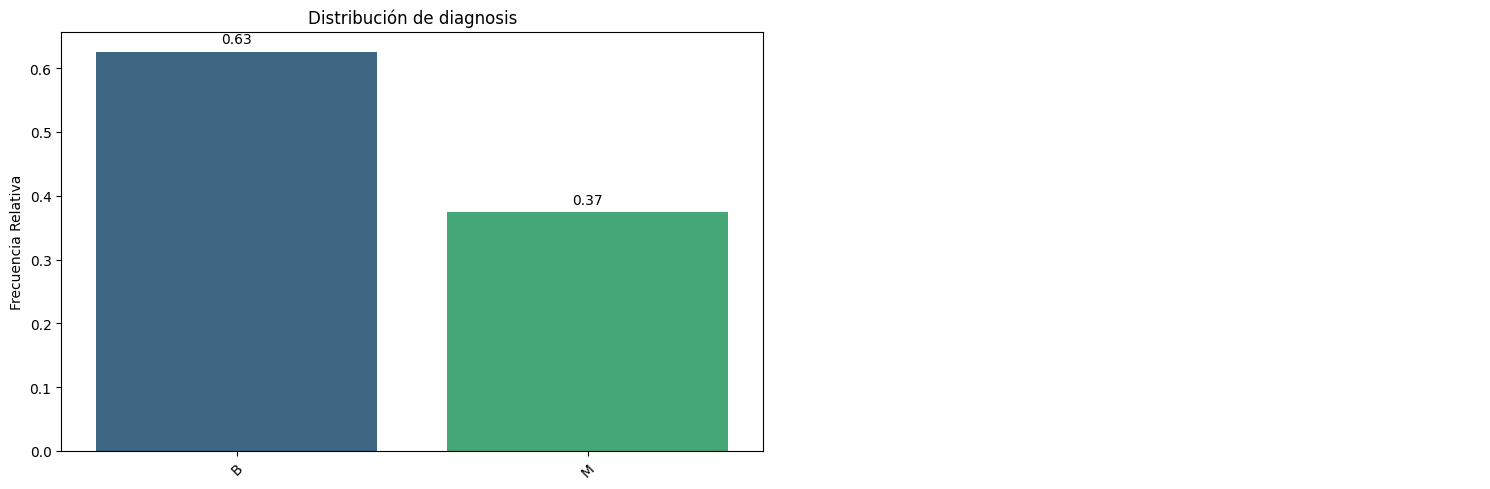

In [8]:
bt.pinta_distribucion_categoricas(train_set, [target], mostrar_valores= True, relativa= True)

*Tenemos un "clásico" dataset desequilibrado, pero sin llegar a extremos, un "balanced_accuracy" en estos casos suele ser una buena métrica, si las indicaiones de "Negocio" no nos sugieren otra cosa*

### Ejercicio 4: MiniEDA (I) Análisis Visual

Realiza un análisis visual de las features y haz tu selección de primera "división" (que luego usaremos para comparar con otros métodos de selección).

*Como siempre tendremos que distinguir entre características numéricas y categóricas. En este caso sólo hay numéricas. Lo siguiente es tener en cuenta el tipo de target, en este caso categórico. Con lo que haremos es un análisis de histrogramas/kde/distribuciones de cada numérica en función de los valores o etiquetas del target. Podemos emplear hasta tres métodos para representar gráficamente y analizar visualmente las relaciones entre numéricas y target, los dos primeros sone equivalentes realmente.*

***Pairplot**, asignando al argumento hue el nombre de la variable target*  
*- Ventajas: Muestra además del gráfico por target, el resto de scatter plots. Podemos observar correlaciones y colinealidades entre las features*  
*- Desventaja: Es un gráfico muy pesado y para muchas features se hace lento y difícil de visualizar. Hay que partir y al partir perdemos la ventaja anterior*

In [10]:
#sns.pairplot(train_set, hue = target)

*Encuentra tú ahí algo :-)*

***Funciones "caseras"**, que permitan el mismo análisis ahorrándonos las figuras que no necesitamos (por ahora)*  
*- Ventaja: más rápida que el pairplot, tamaños más visibles.*  
*- Desventaja: sólo para las figuras elegidas. El estudio de correlaciones a parte*

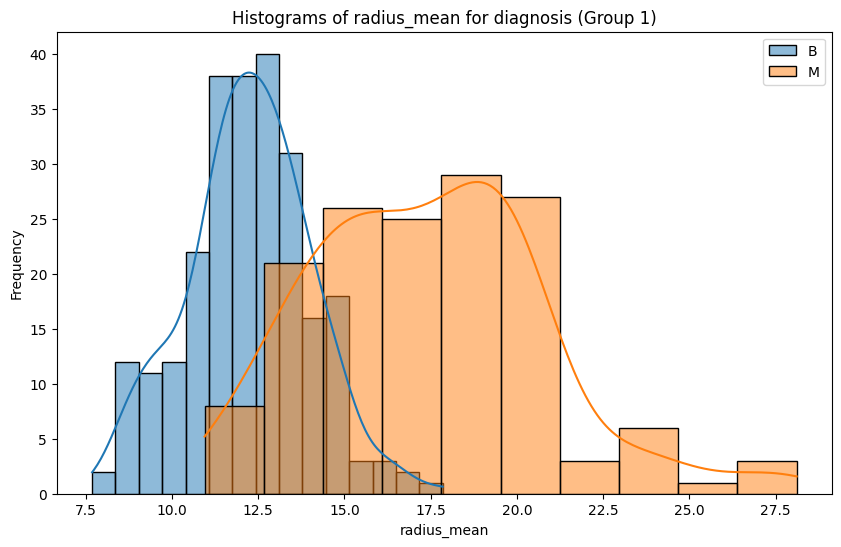

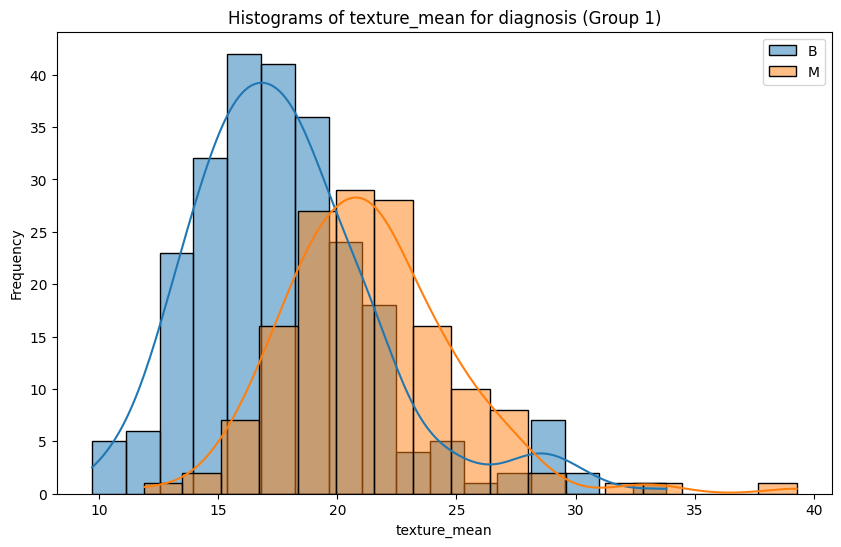

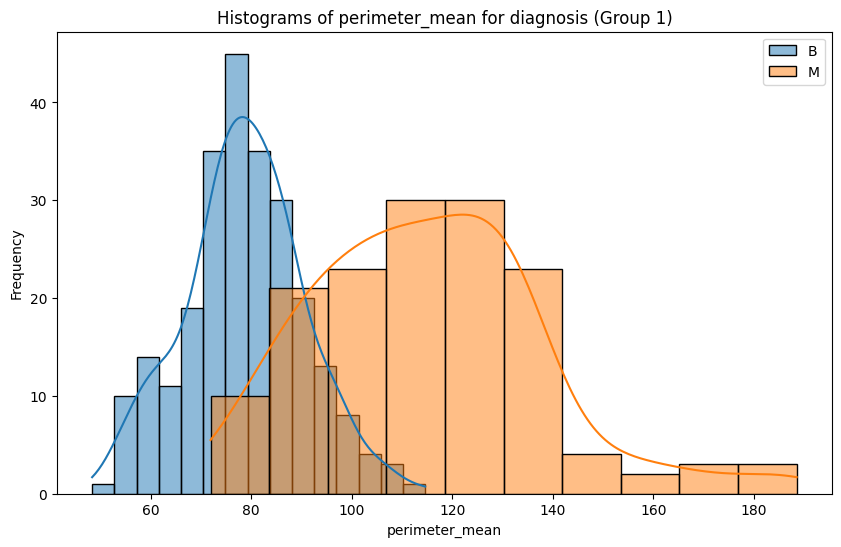

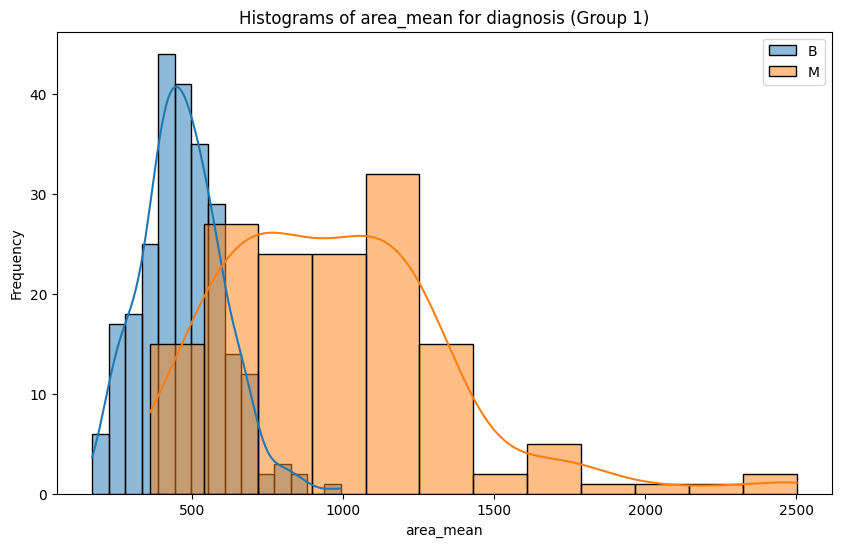

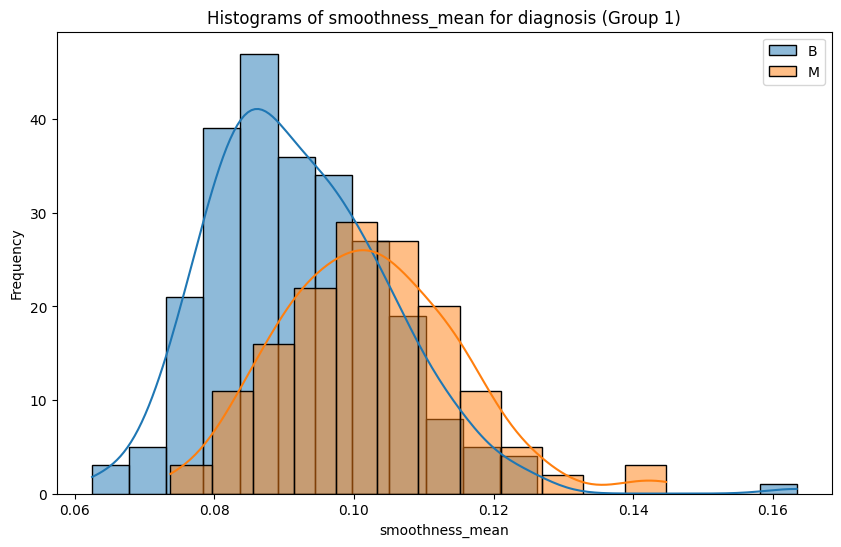

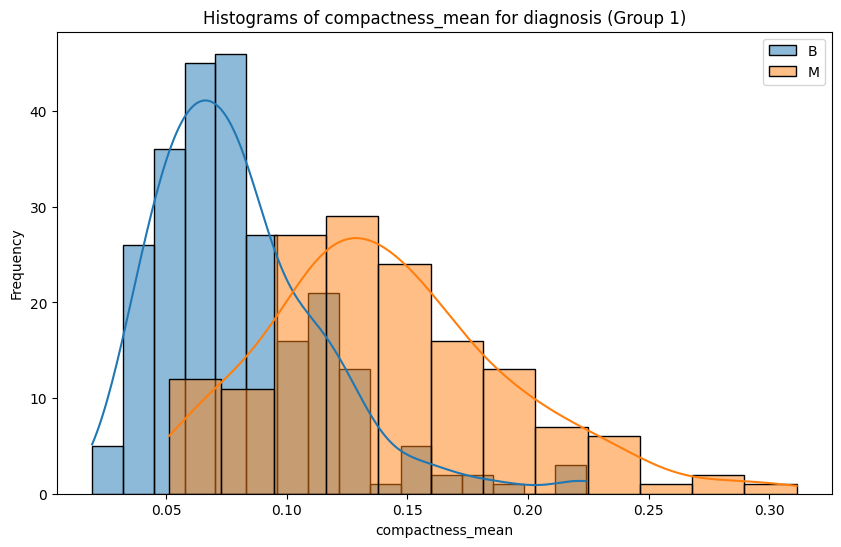

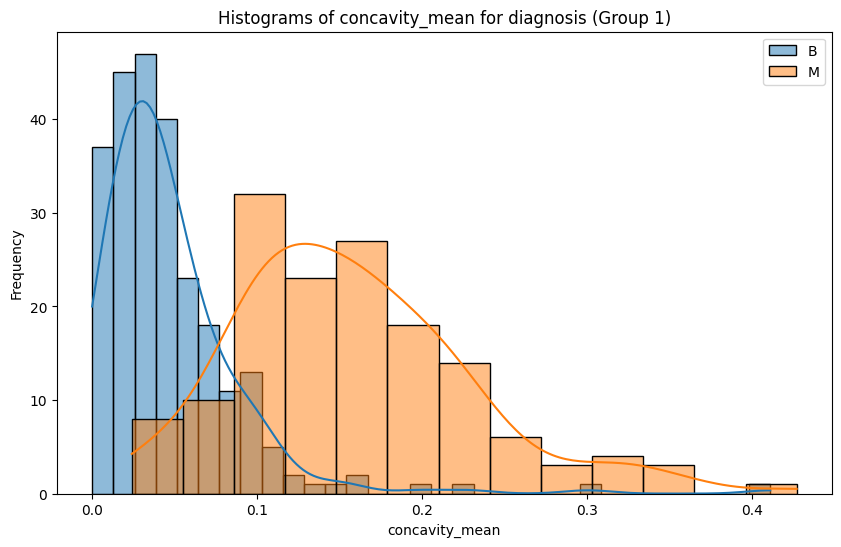

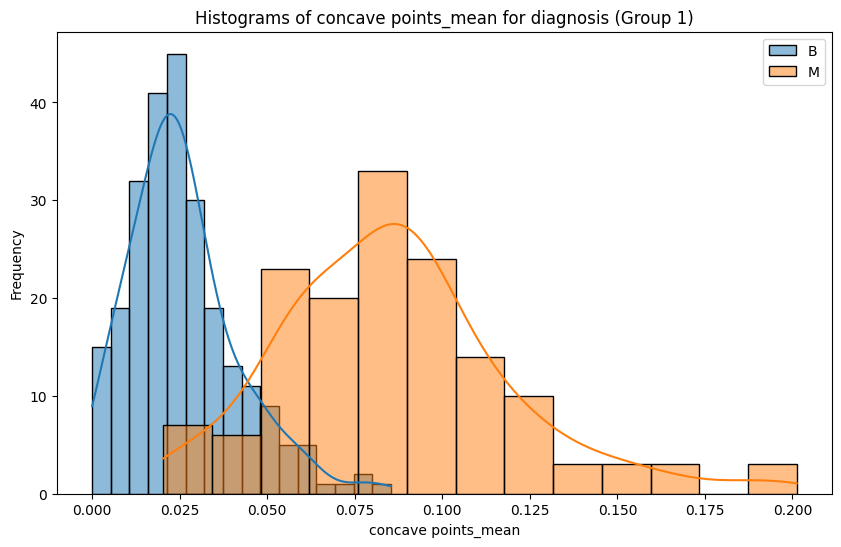

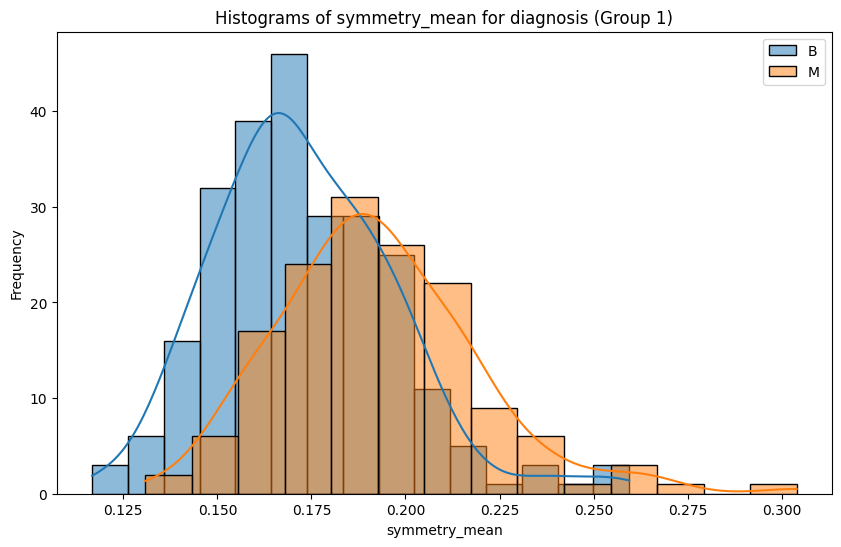

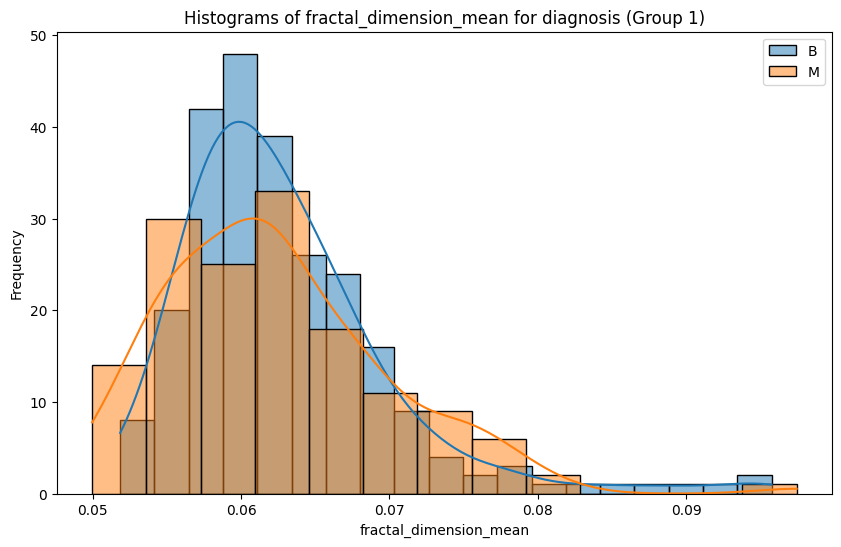

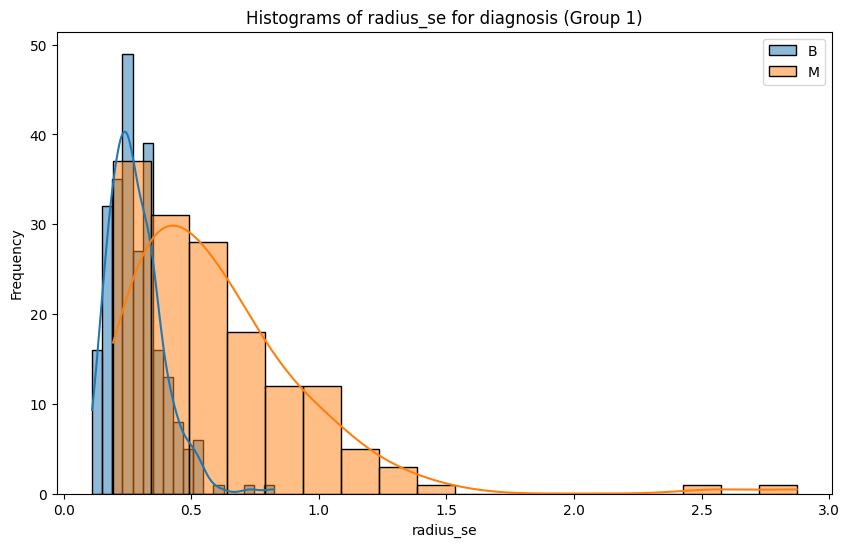

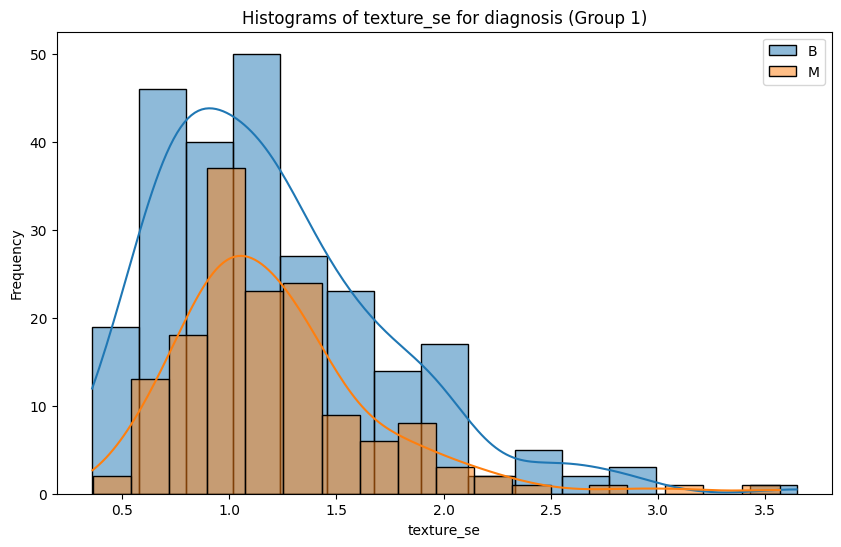

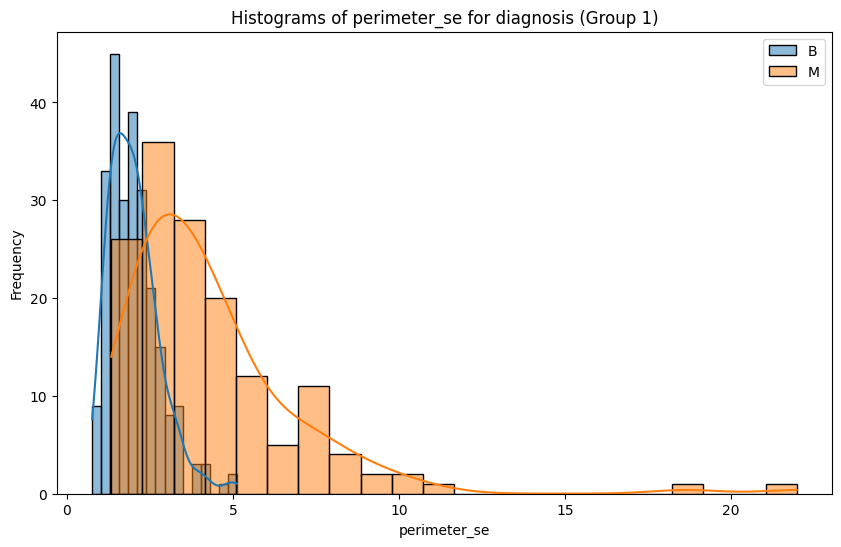

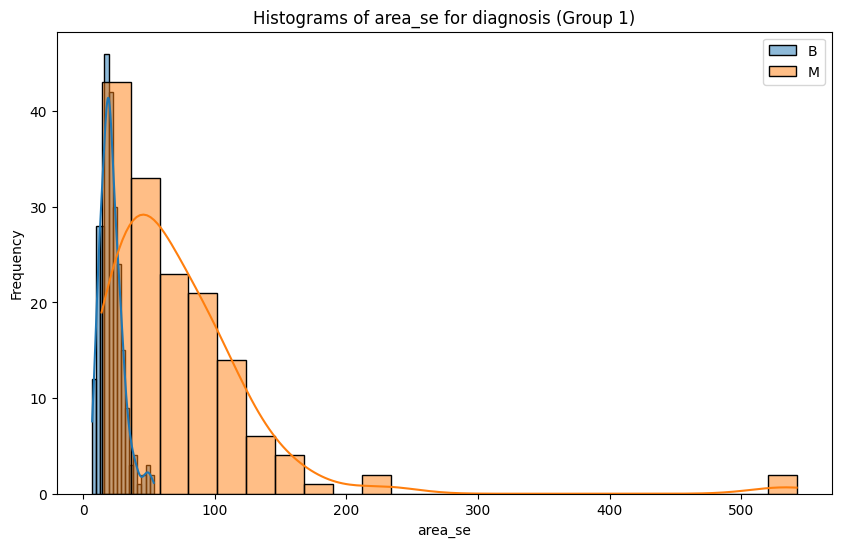

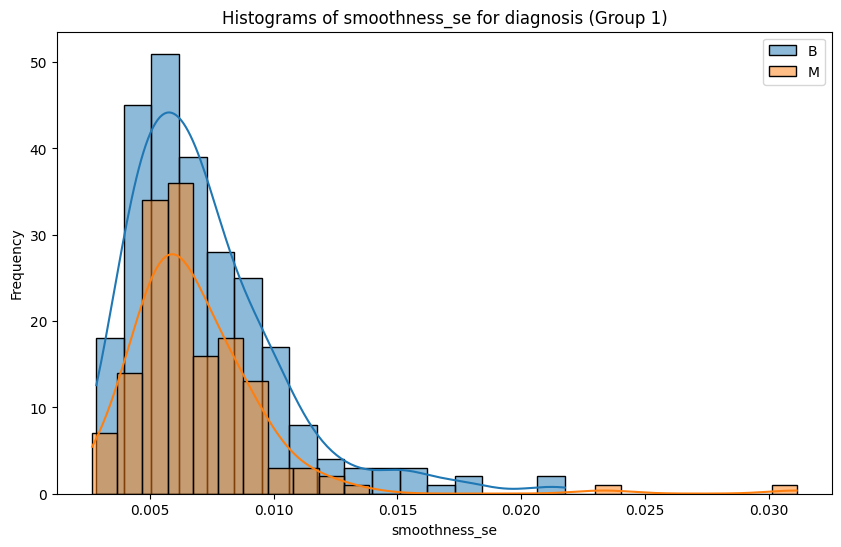

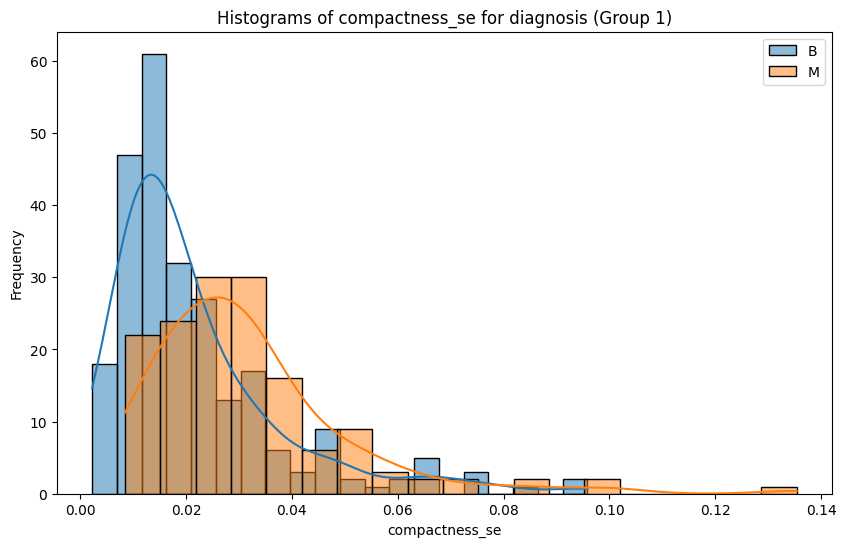

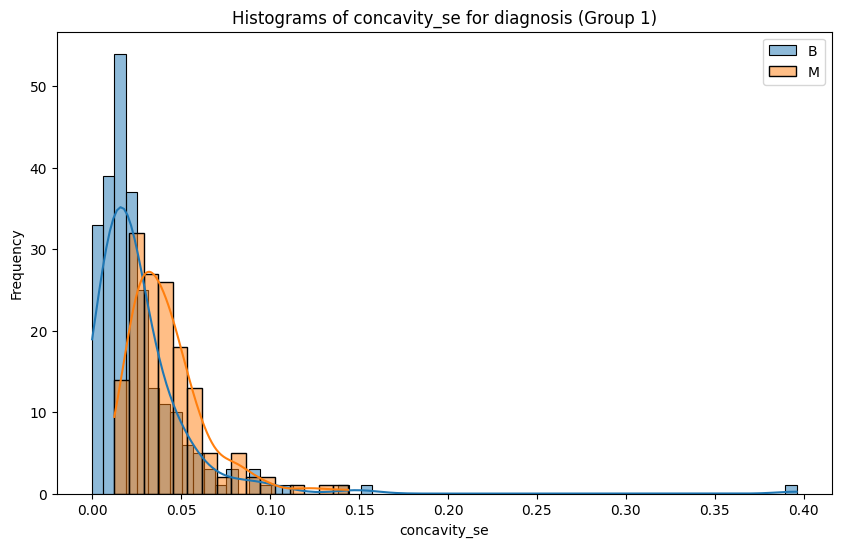

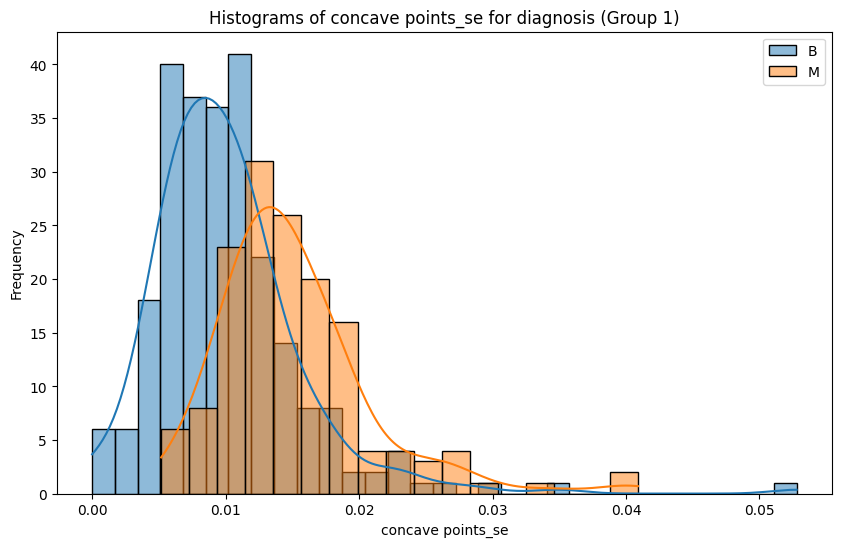

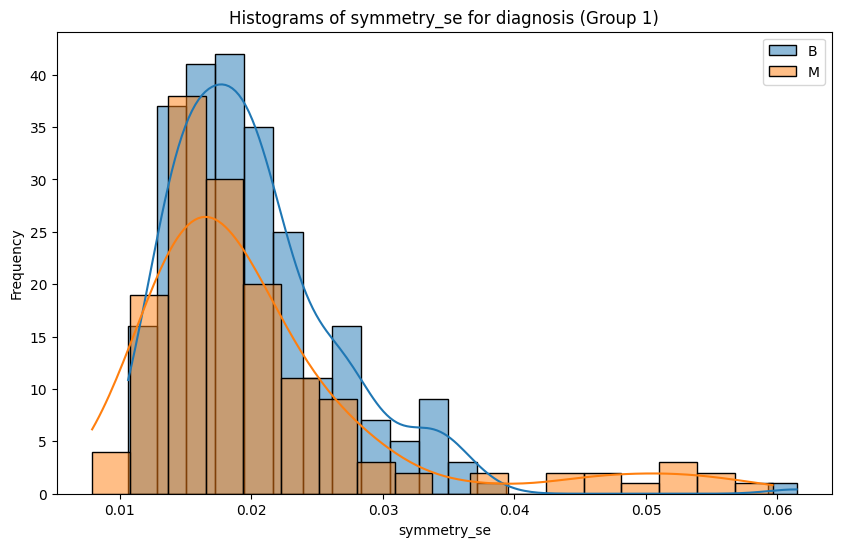

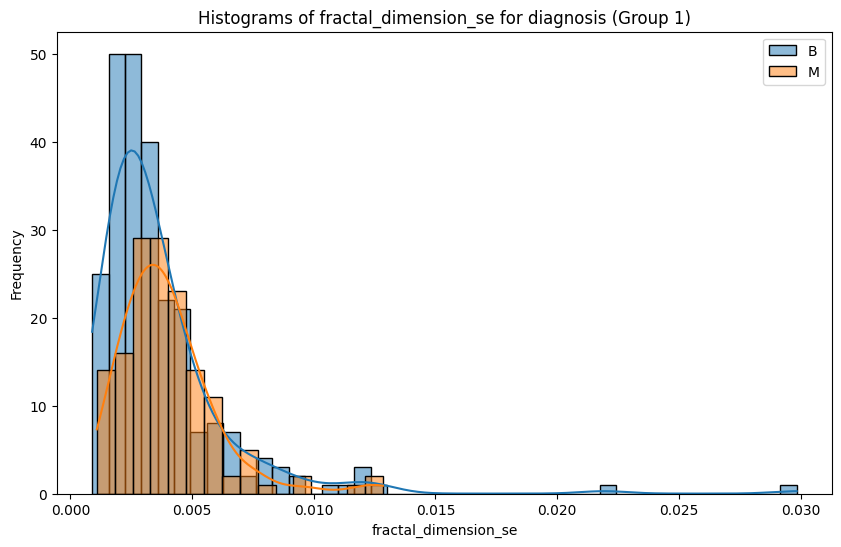

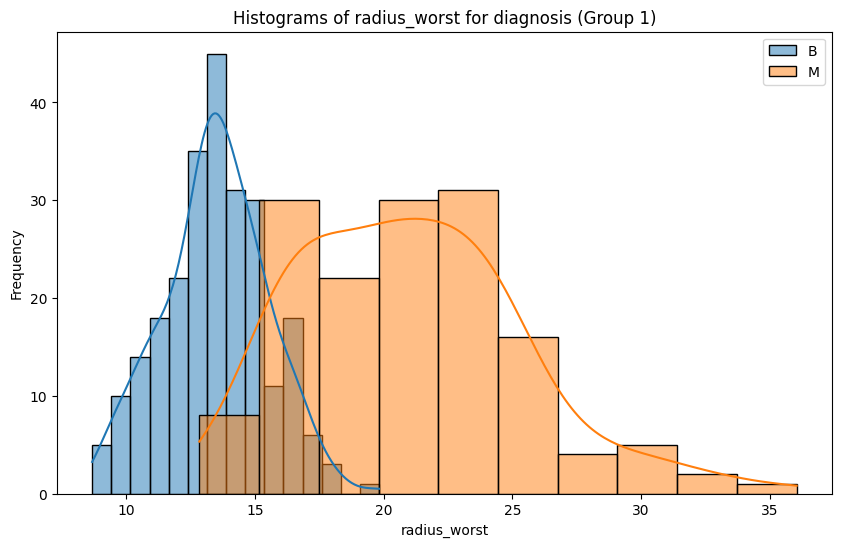

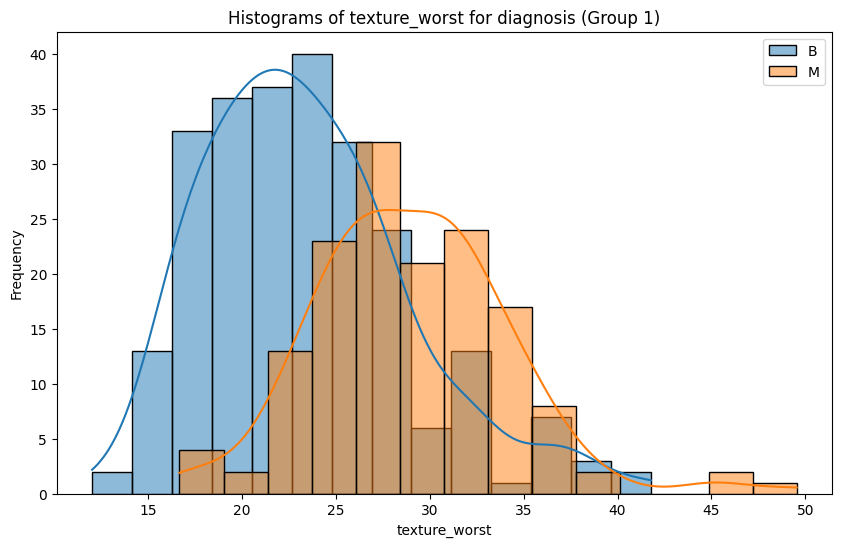

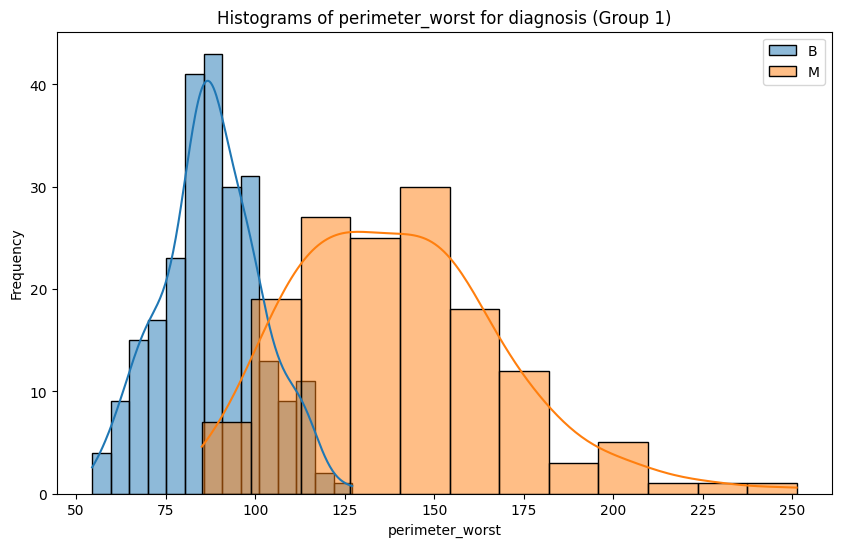

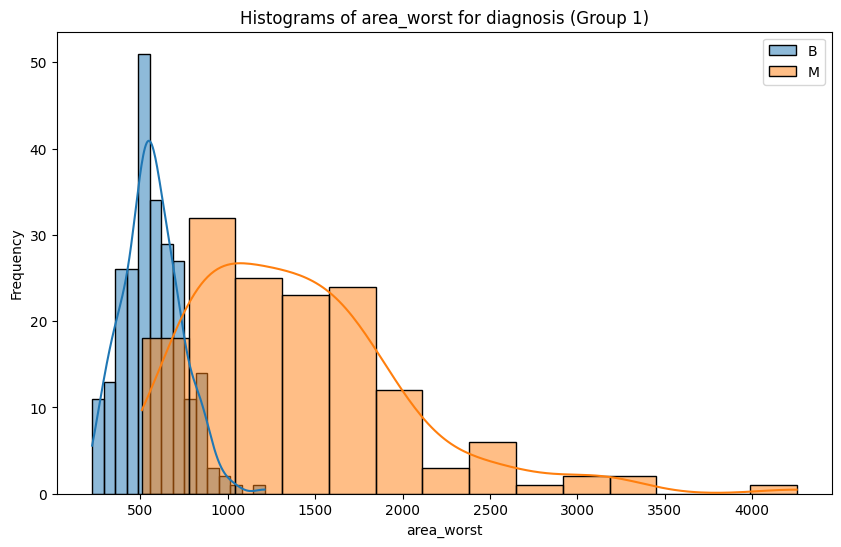

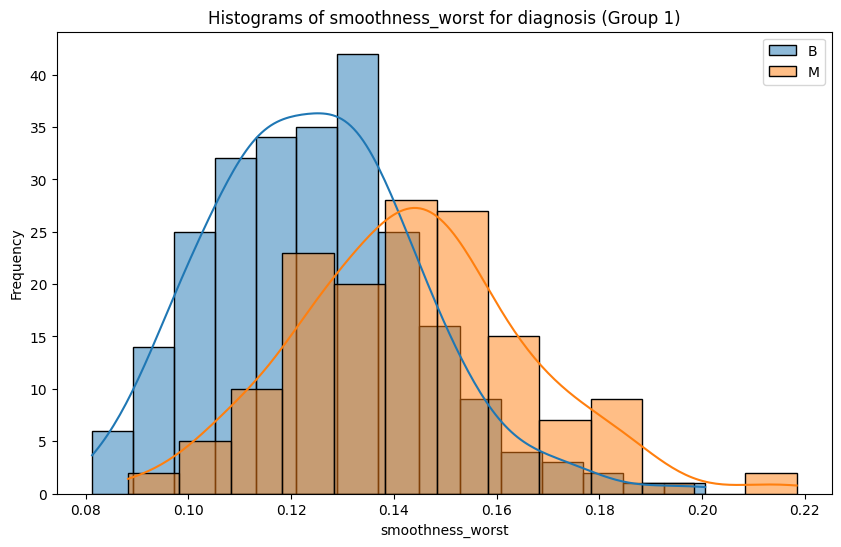

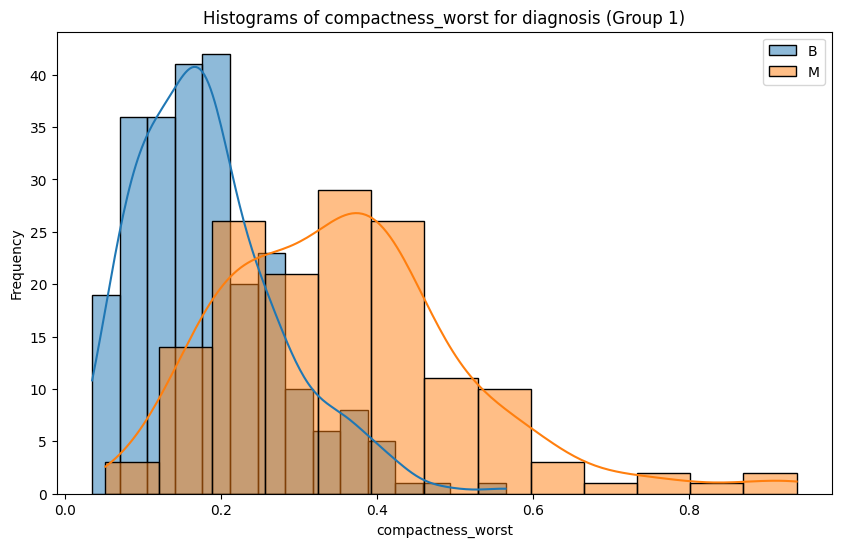

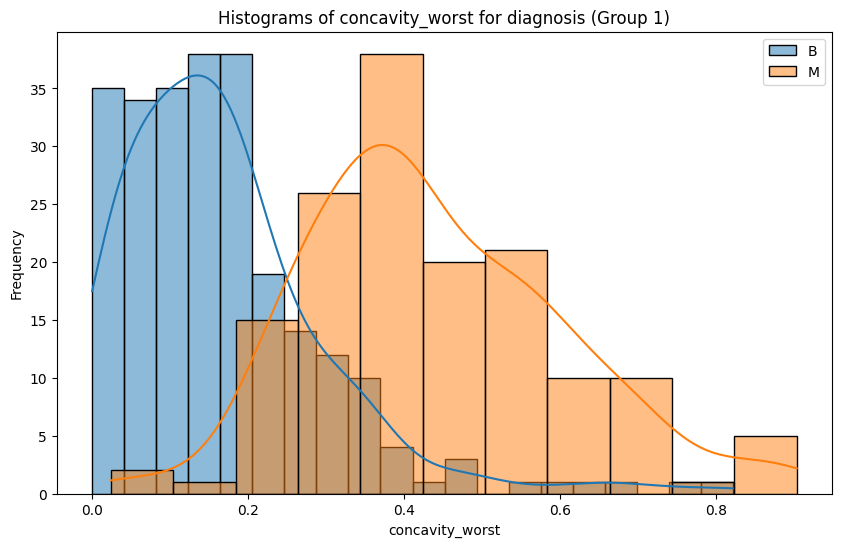

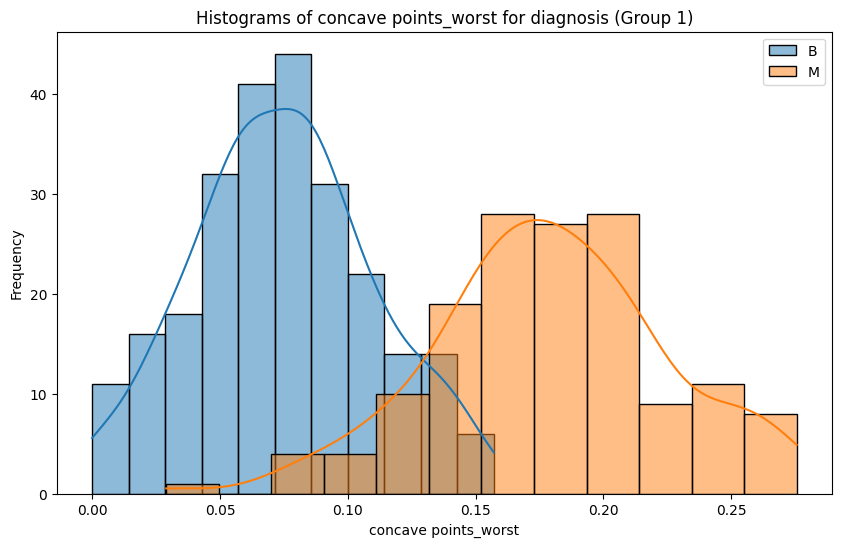

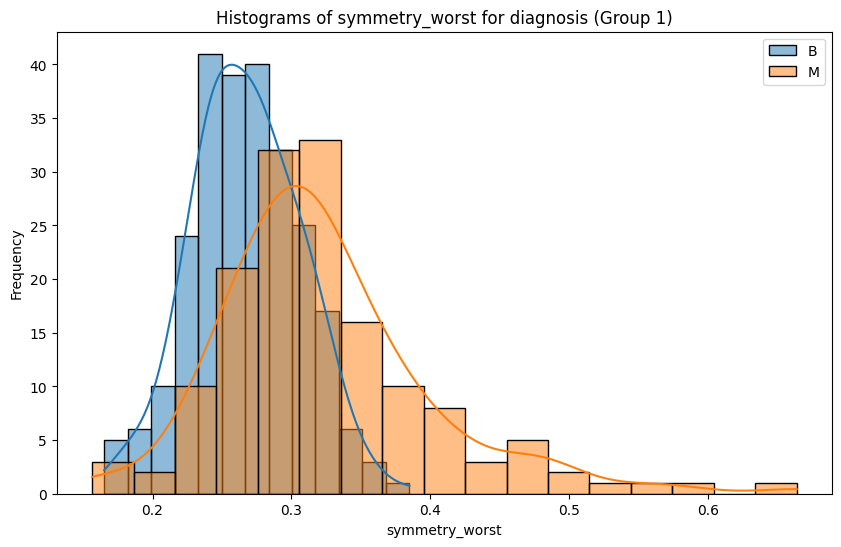

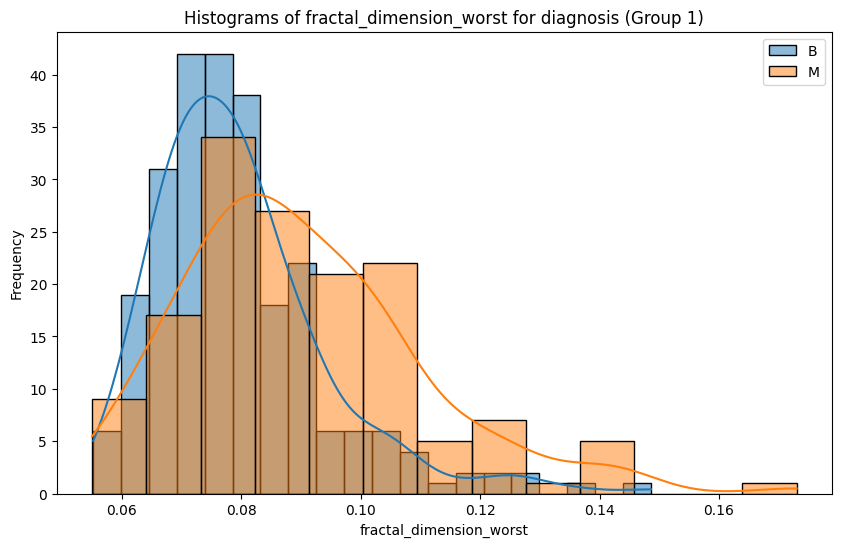

In [ ]:
for col in train_set.columns:
    if col != target:
        bt.plot_grouped_histograms(train_set, target, col, group_size = 2)

*En este caso muchas features tiene muy buena pinta visual, así que partimos de una lista de "segunda división" para luego hacer la de primera por descarte (por cierto, este ejercicio ya lo hicimos en una práctica anterior):*

In [ ]:
features_segunda = ["texture_se","smoothness_se","simmetry_se","fractal_dimension_se"]

*Las dos últimas, aunque tienen cierta capacidad discriminativa, las quito porque el resto es más evidente que aportan*

In [ ]:
features_visual = [col for col in train_set.columns if col not in features_segunda]
features_visual.remove(target)

*Para que tengas una alternativa más, ahora con diagrmas de violín:*

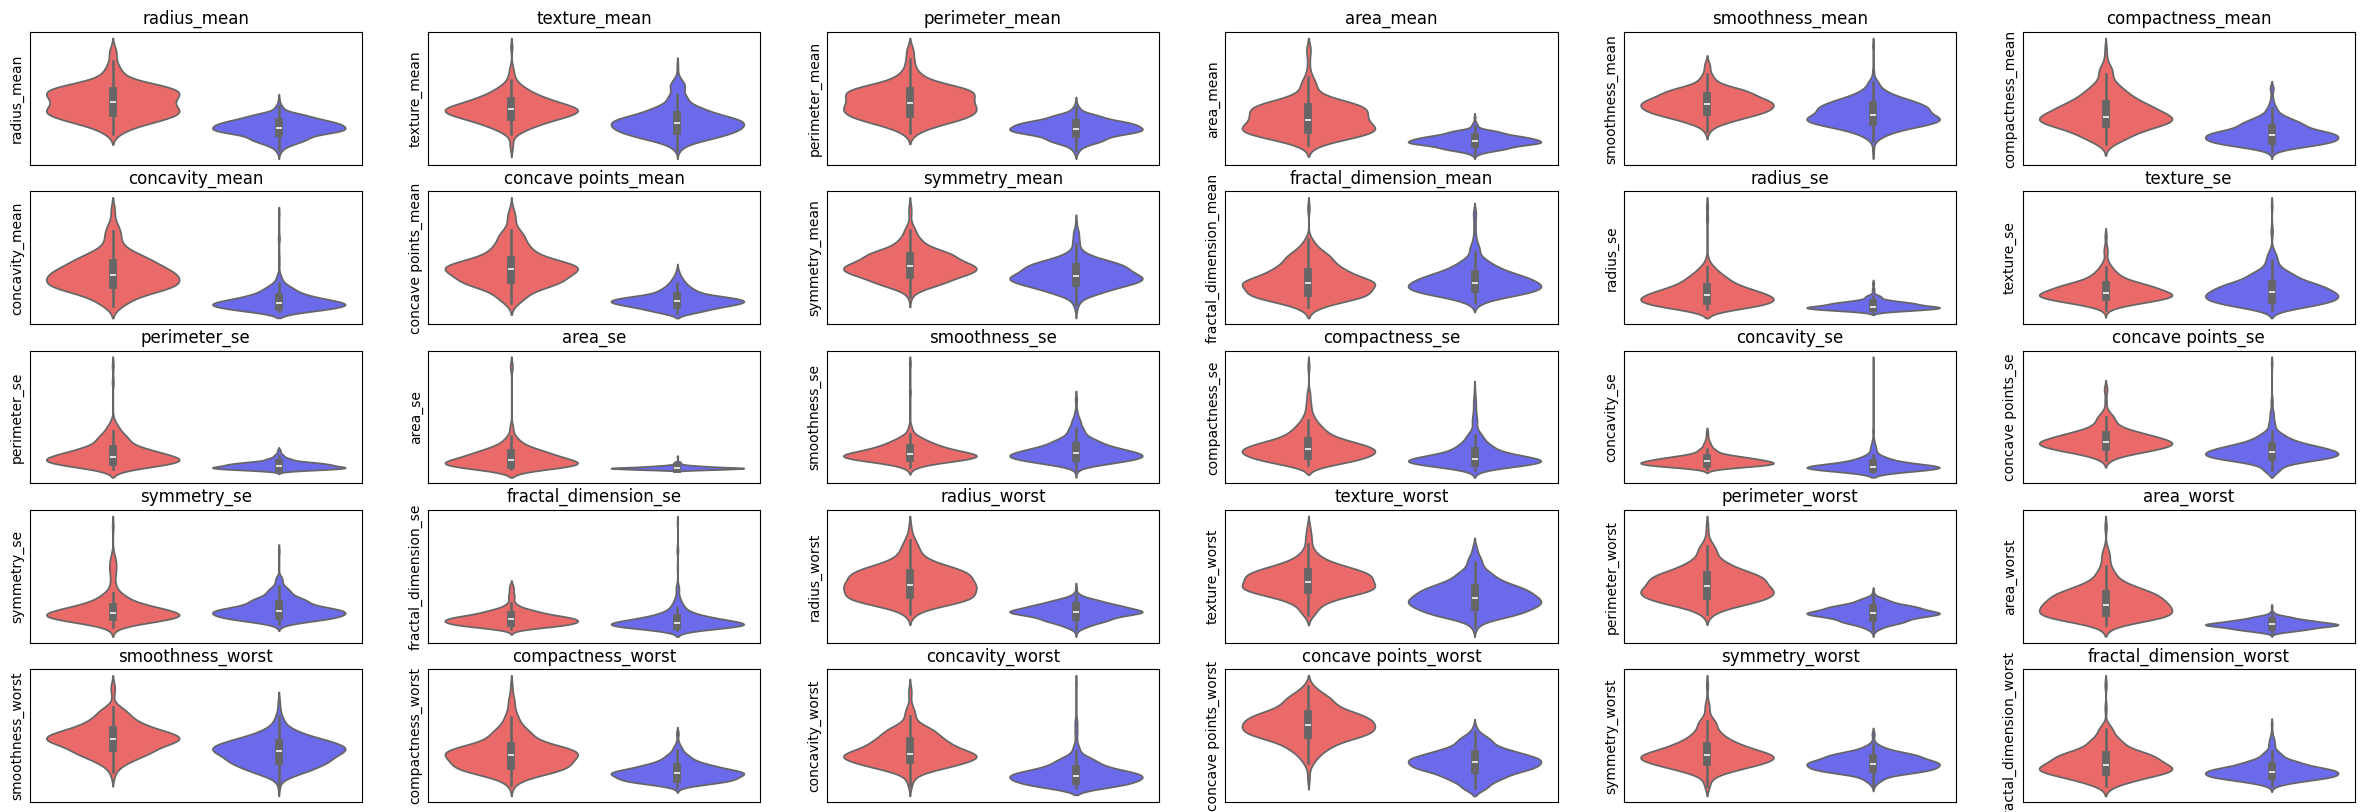

In [ ]:
#Violin plot para ver la distribución de las variables numéricas vs diagnosis
plt.figure(figsize=(30, 10))
for i, col in enumerate(df_breast_cancer.columns[1:]):
    plt.subplot(5, 6, i+1)
    sns.violinplot(data = df_breast_cancer, x = 'diagnosis', y = col, palette='seismic_r')
    plt.title(col)
    plt.xticks([])
    plt.yticks([])
    plt.xlabel('')

### Ejercicio 5

Observa correlaciones entre las features. Utiliza un gráfico apropiado para ello. ¿Crees que sea posible eliminar algunas features para mejorar el modelo? (No hace falta que lo hagas ahora, lo haremos si es necesario en un ejercicio posterior)

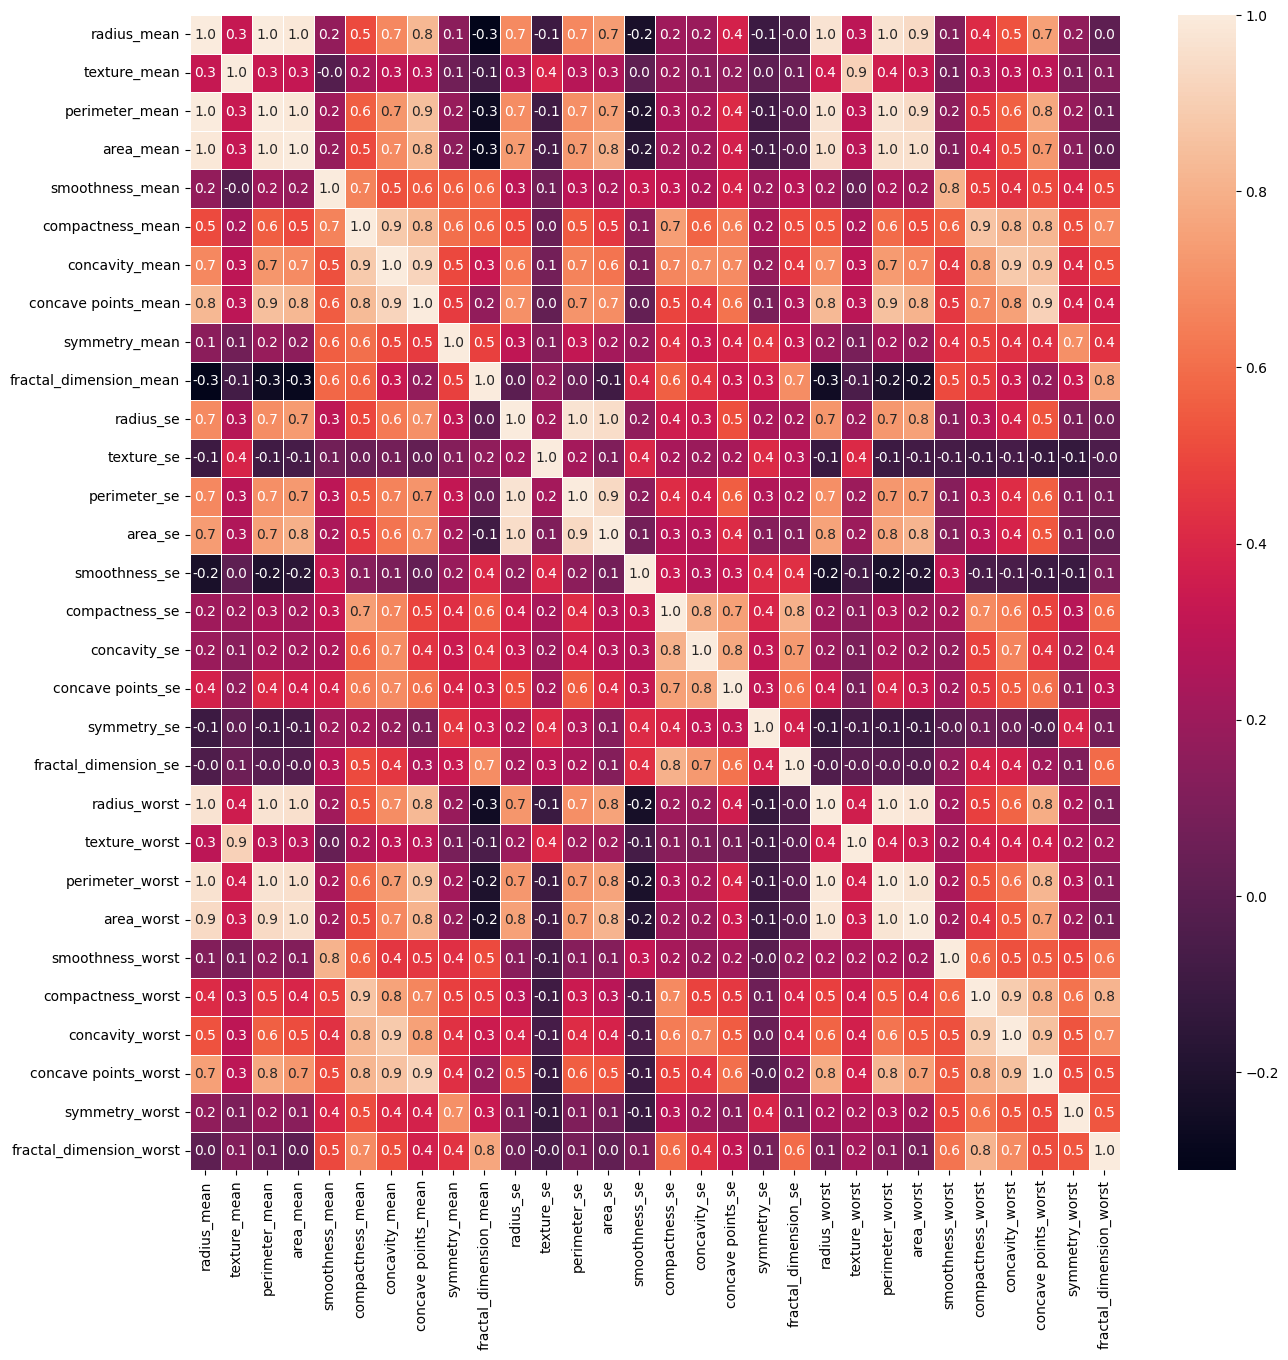

In [ ]:
#correlation map
plt.figure(figsize=(15, 15))
sns.heatmap(df_breast_cancer.corr(numeric_only=True), annot=True, linewidths=.5, fmt= '.1f');

*Existen varias features con correlaciones de 1, es posible que podamos limpiar un poco el ruido ya que estamos enviando al modelo bastante información redundante.*

A continuación vamos a probar distintos métodos para reducir la dimensionalidad, pero primero creemos un modelo que nos sirva como baseline para saber como afecta la selección de features al perfomance del modelo.

### Ejercicio 6:

Entrena (con validación cruzada) un modelo de RandomForestClassifier (con max_depth a 5) con todas las features (ojo incluso las que descartamos en el ejercicio 4) y guarda el perfomance ("balanced_accuracy") en test en una variable. Será nuestro base line de comparación

In [ ]:
X_train = train_set.drop(target, axis = 1)
y_train = train_set[target]

In [ ]:
rfc = RandomForestClassifier(n_estimators=100, random_state=42, max_depth=5)


In [ ]:
baseline = np.mean(cross_val_score(rfc,X_train,y_train, scoring = "balanced_accuracy", cv = 5))
print(f"Baseline: {baseline}%")

Baseline: 0.9387919305653296%


*Obtuvimos un muy buen balanced_accuracy, sin embargo estamos utilizando 30 features lo cual puede ser complicado a la hora de interpretar o poner en producción, además de consumir mas recursos computacionales. ¿Podemos obtener un valor más o menos similar con menos features? Probemos.*

### Ejercicio 7

Vamos a emplear nuestras features del análisis visual pero descartando variables correladas entre sí (emplea la matriz ya obtenida en el ejercicio 5 o bien cualquier medio que creas conveniente). Descarta features y muestra la matriz de correlación para la selección final (recuerda, parte de la lista creada en el ejercicio 4)

Correladas: **radius_mean**, **perimeter_mean**, **area_mean** --> Usamos **area_mean**

Correladas:  **Compactness_mean**, **concavity_mean**,  **concave points_mean** --> Usamos **concavity_mean**

Correladas: **radius_se**, **perimeter_se**, **area_se** --> Usamos **area_se**

Correladas: **radius_worst**, **perimeter_worst**, **area_worst** --> Usamos **area_worst**.

Correladas: **Compactness_worst**, **concavity_worst**,  **concave points_worst** --> Usamos **concavity_worst**

Correladas: **Compactness_se**, **concavity_se**, **concave points_se** --> Usamos **concavity_se**..

Correladas: **area_worst**, **area_mean**, **area_se** --> Usamos **area_mean**.

Correladas: **concacivity_worst**, **concavity_mean** --> Usamos **concavity_worst**

Correladas: **fractal_dimension_mean**, **fractal_dimension_worst** --> Usamos cualquiera: **fractal_dimension_mean**

Correladas: **smoothness_mean**, **smoothness_worst** -->Comparando plot_grouped_histograms: **smoothness_worst**

*Esta es una selección de features un poco a ojo. De hecho sería más interesante ver cual de cada grupo visualmente discrimina mejor o hacer un ANOVA para cada grupo. Tener el hecho de que no entendemos tan bien las variables, siempre es útil el conocimiento de negocio para realizar este tipo de eliminación.*

In [ ]:
drop_list = ['perimeter_mean','radius_mean','compactness_mean',
             'concave points_mean','radius_se','perimeter_se',
             'radius_worst','perimeter_worst','compactness_worst',
             'concave points_worst','compactness_se','concave points_se',
             'texture_worst','area_worst', 'area_se', 'concavity_mean',
             'fractal_dimension_mean','smoothness_mean']

features_visual_final  = [col for col in features_visual if col not in drop_list]
    

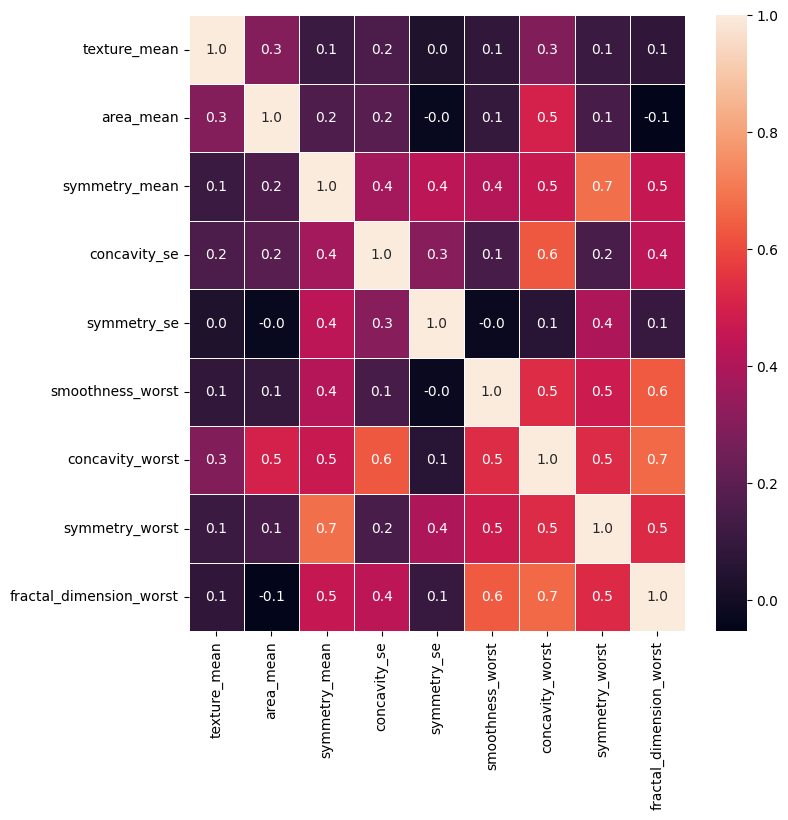

In [ ]:
#correlation map
plt.figure(figsize=(8, 8))
sns.heatmap(X_train[features_visual_final].corr(), annot=True, linewidths=.5, fmt= '.1f');

*Por lo menos en cuanto a matriz de correlaciones ha quedado bastante niquelada*

### Ejercicio 8

Evalúa tu primer feature reduction. Entrena un modelo y evalúa su perfomance con los features que seleccionaste en el ejercicio anterios (emplea la validación cruzada)

In [ ]:
#Train test split
X_train_visual = X_train[features_visual_final]

#Random Forest Classifier
rfc_1 = RandomForestClassifier(n_estimators=100, random_state=42, max_depth=5)

visual_score = np.mean(cross_val_score(rfc_1, X_train_visual, y_train, cv = 5, scoring= "balanced_accuracy"))
num_feats_visual = len(features_visual_final)
num_feats_baseline = len(X_train.columns)
print(f"Visual: {visual_score*100.0}%/{len(features_visual_final)} feats. vs Baseline: {baseline*100.0}%/{num_feats_baseline} feats.")

Visual: 94.2125263898663%/9 feats. vs Baseline: 93.87919305653296%/30 feats.


*Nada mal, de 30 a 9 y encima mejora... Así queremos todas. Sigamos probando*

### Ejercicio 9

Prueba ahora a hacer una feature selection utilizando ANOVA. Compara la validación cruzada con la del modelo baseline y con la del modelo anterior. (Pista: SelectKbest)

*La cantidad de features ideal con ANOVA normalmente se obtiene luego de probar con varias cantidades, si tenemos una intuición de cual puede ser el número ideal luego del análisis de datos también podemos tirar de allí, el objetivo siempre será reducir la máxima cantidad de features con el menor coste en cuanto a perfomance. En este caso podemos usar 5 por simplicidad. Aplicamos ANOVA con el f-test ya que se adapta a nuestra problemática de utilizar variables continuas para predecir un target categórico.*

In [ ]:
# Encontrar las 5 mejores características
num_feats_anova = 5
select_feature = SelectKBest(f_classif, k=num_feats_anova).fit(X_train, y_train)

*Fíjate en el uso del atributo Score de SelectKBest para ordenar las variables*

In [ ]:
best_features_sorted = pd.DataFrame({'Feature': X_train.columns, 'Score': select_feature.scores_}).sort_values(by='Score', ascending=False)
features_anova = select_feature.get_feature_names_out()
best_features_sorted.head()


,Feature,Score
27,concave points_worst,662.320337
7,concave points_mean,616.646516
22,perimeter_worst,580.041174
20,radius_worst,547.254347
2,perimeter_mean,443.061554


In [ ]:
print(features_anova)

['perimeter_mean' 'concave points_mean' 'radius_worst' 'perimeter_worst'
 'concave points_worst']


*Las mejores features son **concavity_mean**, **area_mean**, **concavity_worst**, **area_se** y **symmetry_worst**. Evaluamos el modelo con estas features.*

In [ ]:
# Transformar el dataset a solo las 5 mejores características
X_train_anova = select_feature.transform(X_train)


#Random Forest Classifier
rfc_2 = RandomForestClassifier(n_estimators=100, random_state=42, max_depth=5)

anova_score = np.mean(cross_val_score(rfc_1, X_train_anova, y_train, cv = 5, scoring= "balanced_accuracy"))

print(f"ANOVA: {anova_score*100.0}%/{num_feats_anova} feats. vs Baseline: {baseline*100.0}%/{num_feats_baseline} feats.")

ANOVA: 92.35735397607317%/5 feats. vs Baseline: 93.87919305653296%/30 feats.


*Perdemos potencia, ligeramente pero ya nos quedasmo en 5/30 features, no está mal*

*Comparemos features con nuestro análisis visual*

*No en visual, sí en ANOVA:*

In [ ]:
print([col for col in features_anova if col not in features_visual_final])

['perimeter_mean', 'concave points_mean', 'radius_worst', 'perimeter_worst', 'concave points_worst']


*No hay coincidencias!!! Pero recuerda que hay muchas correladas que serían representantes de las anteriores (de hecho en esta selección hay dos variables perimeter que igual podríamos haber simplificado. ESA ES IMPORTANTE una selección tipo ANOVA no analiza correlaciones entre las features solo entre cada feature y el target, podemos nosotros hacer una segunda derivada y también realimentar nuestro análisis visual con el ANOVA y viceversa*

### Ejercicio 10

Prueba a hacer ahora una selección de features con RFE (Recursive Feature Elimination), hasta quedarte con 5 features. Evalúa perfomance en "balanced_accuracy" con cross_validation y compara con la baseline.

In [ ]:
from sklearn.feature_selection import RFE

#Random Forest Classifier
rfc_3 = RandomForestClassifier(n_estimators=100, random_state=42, max_depth=5)

#Recursive Feature Elimination y entrenar el modelo
num_feats_rfe = 5
rfe = RFE(estimator=rfc_3, n_features_to_select= num_feats_rfe, step=1)
rfe = rfe.fit(X_train, y_train)
X_train_rfe = rfe.transform(X_train)

rfe_score = np.mean(cross_val_score(rfc_3, X_train_rfe, y_train, cv = 5, scoring= "balanced_accuracy"))

print(f"ANOVA: {rfe_score*100.0}%/{num_feats_anova} feats. vs Baseline: {baseline*100.0}%/{num_feats_baseline} feats.")


ANOVA: 92.42402064273986%/5 feats. vs Baseline: 93.87919305653296%/30 feats.


In [ ]:
features_rfe = rfe.get_feature_names_out()
features_rfe

array(['concave points_mean', 'radius_worst', 'perimeter_worst',
       'area_worst', 'concave points_worst'], dtype=object)

*Se obtiene una mejor métrica ligeramente que en el caso anterior y todavía peor que con todas y peor que con el análisis visual corregido por quitar colinearidades*

*Otro aspecto importante es que RFE no admite scoring para seleccionar las features, por lo que realmente ha obtenido las features para mejorar el score del RandomForestClassifier que por defecto es el accuracy. Aun así lo ha hecho bastante bien.*

### Ejercicio 11

Prueba a eliminar features con el modelo de RandomForestClassifier (emplea SelectFromModel de sklearn). Utiliza esta vez una regresión logística para entrenar con las features escogidas y compara con el baseline. Muestra primero la importancia obtenida con el modelo baseline (que básicamente es el mismo que vamos a usar con SelectFromModel). Prueba primero para features por encima de la mediana y luego para las 5 primeras.

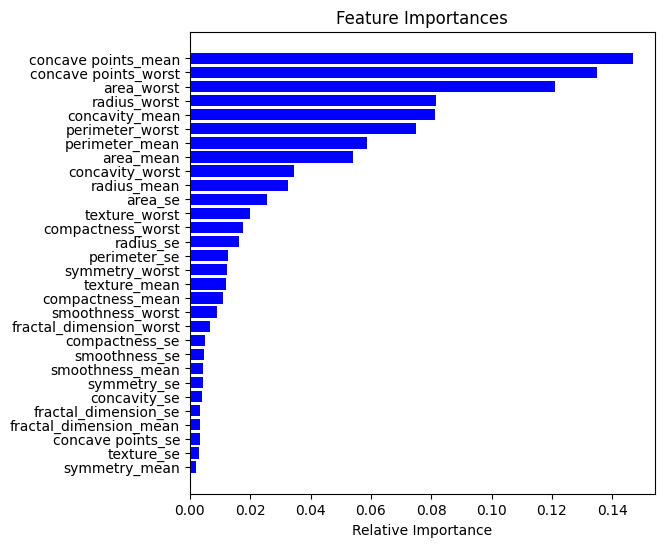

In [ ]:
#mostramos la importancia de las características del modelo original (sin reducción de características)
rfc.fit(X_train,y_train)
importances = rfc.feature_importances_
indices = np.argsort(importances)

plt.figure(figsize=(6, 6))
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [X_train.columns[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

*Para las features superiores a la mediana*

In [ ]:
from sklearn.feature_selection import SelectFromModel


selector_model = SelectFromModel(estimator = rfc, threshold= "median") 
selector_model.fit(X_train,y_train)
print("Escogidas:", selector_model.get_feature_names_out())

Escogidas: ['radius_mean' 'perimeter_mean' 'area_mean' 'concavity_mean'
 'concave points_mean' 'radius_se' 'perimeter_se' 'area_se' 'radius_worst'
 'texture_worst' 'perimeter_worst' 'area_worst' 'compactness_worst'
 'concavity_worst' 'concave points_worst']


In [ ]:
from sklearn.linear_model import LogisticRegression

lc_clf = LogisticRegression(max_iter = 1000)
X_train_model_median = selector_model.transform(X_train)
score_model_median = np.mean(cross_val_score(lc_clf, X_train_model_median, y_train, cv = 5, scoring = "balanced_accuracy"))
num_features_model_median = X_train_model_median.shape[1]
print(f"LR: {score_model_median*100.0}%/{num_features_model_median} feats. vs Baseline: {baseline*100.0}%/{num_feats_baseline} feats.")


LR: 93.20844475721323%/15 feats. vs Baseline: 93.87919305653296%/30 feats.


*para las 5 mejores según el randomforest*

In [ ]:
selector_model = SelectFromModel(estimator = rfc, threshold= "median", max_features= 5) 
selector_model.fit(X_train,y_train)
print("Escogidas:", selector_model.get_feature_names_out())

lc_clf = LogisticRegression(max_iter = 1000)
X_train_model_median = selector_model.transform(X_train)
score_model_median = np.mean(cross_val_score(lc_clf, X_train_model_median, y_train, cv = 5, scoring = "balanced_accuracy"))
num_features_model_median = X_train_model_median.shape[1]
print(f"LR: {score_model_median*100.0}%/{num_features_model_median} feats. vs Baseline: {baseline*100.0}%/{num_feats_baseline} feats.")

Escogidas: ['concavity_mean' 'concave points_mean' 'radius_worst' 'area_worst'
 'concave points_worst']
LR: 88.84062866525922%/5 feats. vs Baseline: 93.87919305653296%/30 feats.


### Ejercicio EXTRA:

Investiga RFECV y obten el número optimo de features siguiendo esta técnica pero con el "balanced_accuracy" como métrica.

In [ ]:
#Rfe con cross validation
from sklearn.feature_selection import RFECV

rfc_4 = RandomForestClassifier() 
rfecv = RFECV(estimator=rfc_4, step=1, cv=5,scoring='balanced_accuracy')
rfecv = rfecv.fit(X_train, y_train)

print('Optimal number of features :', rfecv.n_features_)
print('Best features :', list(X_train.columns[rfecv.support_]))
print("Best features (alternative):", rfecv.get_feature_names_out())
print('Accuracy feat. reduction 4:', np.mean(cross_val_score(rfc_4, X_train[rfecv.get_feature_names_out()],y_train, cv = 5, scoring = "balanced_accuracy")))

Optimal number of features : 15
Best features : ['radius_mean', 'texture_mean', 'perimeter_mean', 'area_mean', 'concavity_mean', 'concave points_mean', 'area_se', 'radius_worst', 'texture_worst', 'perimeter_worst', 'area_worst', 'compactness_worst', 'concavity_worst', 'concave points_worst', 'symmetry_worst']
Best features (alternative): ['radius_mean' 'texture_mean' 'perimeter_mean' 'area_mean'
 'concavity_mean' 'concave points_mean' 'area_se' 'radius_worst'
 'texture_worst' 'perimeter_worst' 'area_worst' 'compactness_worst'
 'concavity_worst' 'concave points_worst' 'symmetry_worst']
Accuracy feat. reduction 4: 0.959729298615998


*Observa que hemos encontrado una mejor métrica que con el análisis visual añadiendo alguna feture más, y por supuesto que el baseline que tenía todas las features*

*Podemos observar los accuracy por cantidad de features.*

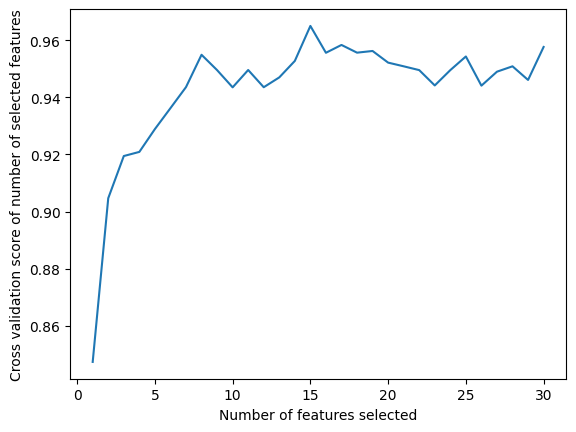

In [ ]:
# Plot number of features VS. cross-validation scores
import matplotlib.pyplot as plt
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score of number of selected features")
plt.plot(range(1, len(rfecv.cv_results_['mean_test_score']) + 1), rfecv.cv_results_['mean_test_score'])
plt.show()

In [ ]:
rfc.feature_importances_.shape

(30,)

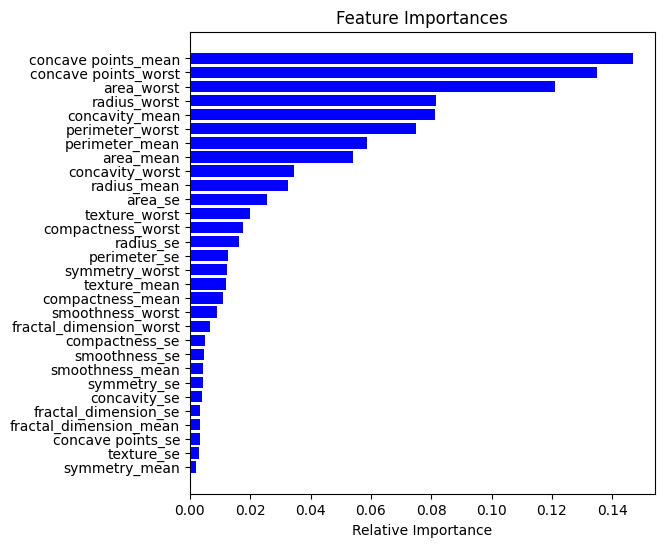

In [ ]:
#Graficar la importancia de las características del modelo original (sin reducción de características)
importances = rfc.feature_importances_
indices = np.argsort(importances)

plt.figure(figsize=(6, 6))
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [X.columns[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

In [ ]:
#Entrenar el modelo con las 4 mejores características

X_train, X_test, y_train, y_test = train_test_split(X[['concave points_mean', 'concave points_worst', 'area_worst']],\
                                                                                                 y, test_size=0.3, random_state=42)
rfc_6 = RandomForestClassifier(n_estimators=100, random_state=42, max_depth=5)
rfc_6.fit(X_train[['concave points_mean', 'concave points_worst', 'area_worst']], y_train)

#Predicciones
y_pred = rfc_6.predict(X_test[['concave points_mean', 'concave points_worst', 'area_worst']])
accuracy = accuracy_score(y_test, y_pred)

#Accuracy
print(f'Accuracy feat. reduction 5: {accuracy:.2f}')
print(f'Accuracy inicial: {accuracy_baseline:.2f}')

Accuracy feat. reduction 5: 0.96
Accuracy inicial: 0.96


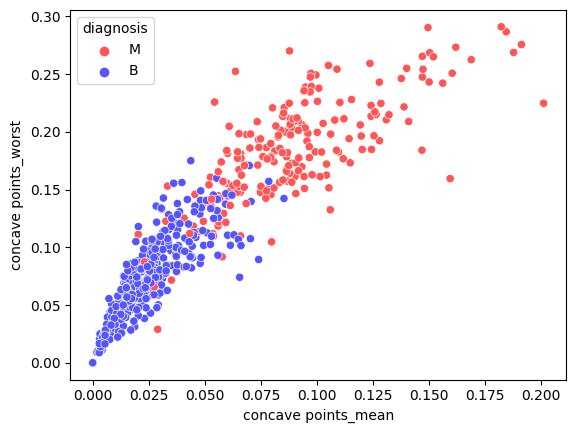

In [ ]:
sns.scatterplot(x='concave points_mean', y='concave points_worst', hue='diagnosis', data=df_breast_cancer, palette='seismic_r');

*Obtenemos resultados bastante buenos comparando la media de concavidad con la cantidad de puntos concavos en los peores escenarios, habíamos eliminado una de estas inicialmente "a ojo" por desconocimiento de negocio.*

### Bonus track: Prueba otros métodos de reducción de features que conozcas.